### Numerical methods for solving ODEs
This notebook illustrates the following numerical algorithms:
* Explicit (forward) Euler
* Implicit (backward) Euler
* Heun
* Trapezoid (which is an implicit method)
* Runge-Kutta

We apply these methods to solve the differential equation $\frac{du}{dt}=-u$ with $u(0)=u_0$ on the interval $[0,T]$. The solution to this problem is given by $u(t)=u_0e^{-t}$, which allows us to compare the numerical solution with the true solution and estimate the error we make in our approximation.

In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt

The following functions provide the code for solving a differential equation using forward Euler, Heun, Runge-Kutta, and the implicit trapezoidal method.

In [2]:
def forward_euler(f, u, dt, t):
    N = len(u)-1
    for n in range(N):
        u[n+1] = u[n] + dt*f(u[n], t[n])
    return u

def backward_euler(f, u, dt, t):
    import scipy.optimize as opt
    N = len(u)-1
    def g(v, f, u, t, dt):
        return v - dt*f(v, t+dt) - u
    for n in range(N):
        u[n+1] = opt.newton(g, u[n], args=(f, u[n], t[n], dt))
    return u

def heun(f, u, dt, t):
    N = len(u)-1
    for n in range(N):
        k1 = f(u[n], t[n]);
        k2 = f(u[n] + dt*k1, t[n] + dt);
        u[n+1] = u[n] + dt/2*(k1 + k2);
    return u

def runge_kutta(f, u, dt, t):
    N = len(u)-1
    for n in range(N):
        k1 = f(u[n], t[n]);
        k2 = f(u[n] + dt/2*k1, t[n] + dt/2);
        k3 = f(u[n] + dt/2*k2, t[n] + dt/2);
        k4 = f(u[n] + dt*k3, t[n] + dt);
        u[n+1] = u[n] + dt/6*(k1 + 2*k2 + 2*k3 + k4)
    return u

def trapezoidal(f, u, dt, t):
    import scipy.optimize as opt
    N = len(u)-1
    def g(v, f, u, t, dt):
        return v - (u + dt/2*(f(u,t) + f(v, t+dt))) 
    for n in range(N):
        u[n+1] = opt.newton(g, u[n], args=(f, u[n], t[n], dt))
    return u

We will use the linear differential equation $\frac{du}{dt}=-u$ with solution given by $u(t)=u_0 e^{-t}$ to explore how well the numerical algorithms approximate solutions.

In [3]:
def test_rhs(u, t):
    return -u

def test_solution(t, u0):
    return u0*np.exp(-t)

Next, we provide the code that will allow us to test the numerical methods against the analytical solution.

In [4]:
def compare_numerical_algorithms(h, T, u0, show_df=True):
    dt = h
    N = int(round(float(T)/dt))
    u = np.zeros(N+1)
    t = np.linspace(0, N*dt, N+1)
    
    # solve using each solver and plot solutions
    fig, ax = plt.subplots(figsize=(6, 6))
    for k, solver in enumerate(solvers):
        u[0] = u0
        u = solver(test_rhs, u, dt, t)
        plt.plot(t, u, linestyle="None", marker=symbols[k])

    # retrieve and plot analytical solution
    ta = np.arange(0, T, 0.01)
    ua = test_solution(ta, u0)
    plt.plot(ta, ua, color='tab:purple', label="Analytical solution")
    legends.append("Analytical solution")
    
    # compute direction field
    X, Y = np.meshgrid(np.arange(0, T+1, dt), np.arange(0, u0+1, 2))
    V = test_rhs(Y, X)
    U = 1 + 0*V
    S = (np.hypot(U, V))
    S[S==0] = 1.0
    U = U/S
    V = V/S
    if show_df:
        ax.quiver(X, Y, U, V, color='tab:green',
                  angles='xy', scale_units='x', scale=1.5/dt, alpha=0.35)

    ax.set(xlabel='time t', ylabel='independent variable u')
    ax.legend(legends)
    plt.show()

Next, we list the solvers we want to use in our comparison and run the code from the previous cell. In addition to the step size `h`, the final time `T`, and the initial condition `u0`, we can also set `show_df=True` or `show_df=False` to shows or hide the direction field. The resulting figure shows the direction field, the numerical solutions, and, for comparison, the true solution (solid purple curve).

<IPython.core.display.Javascript object>


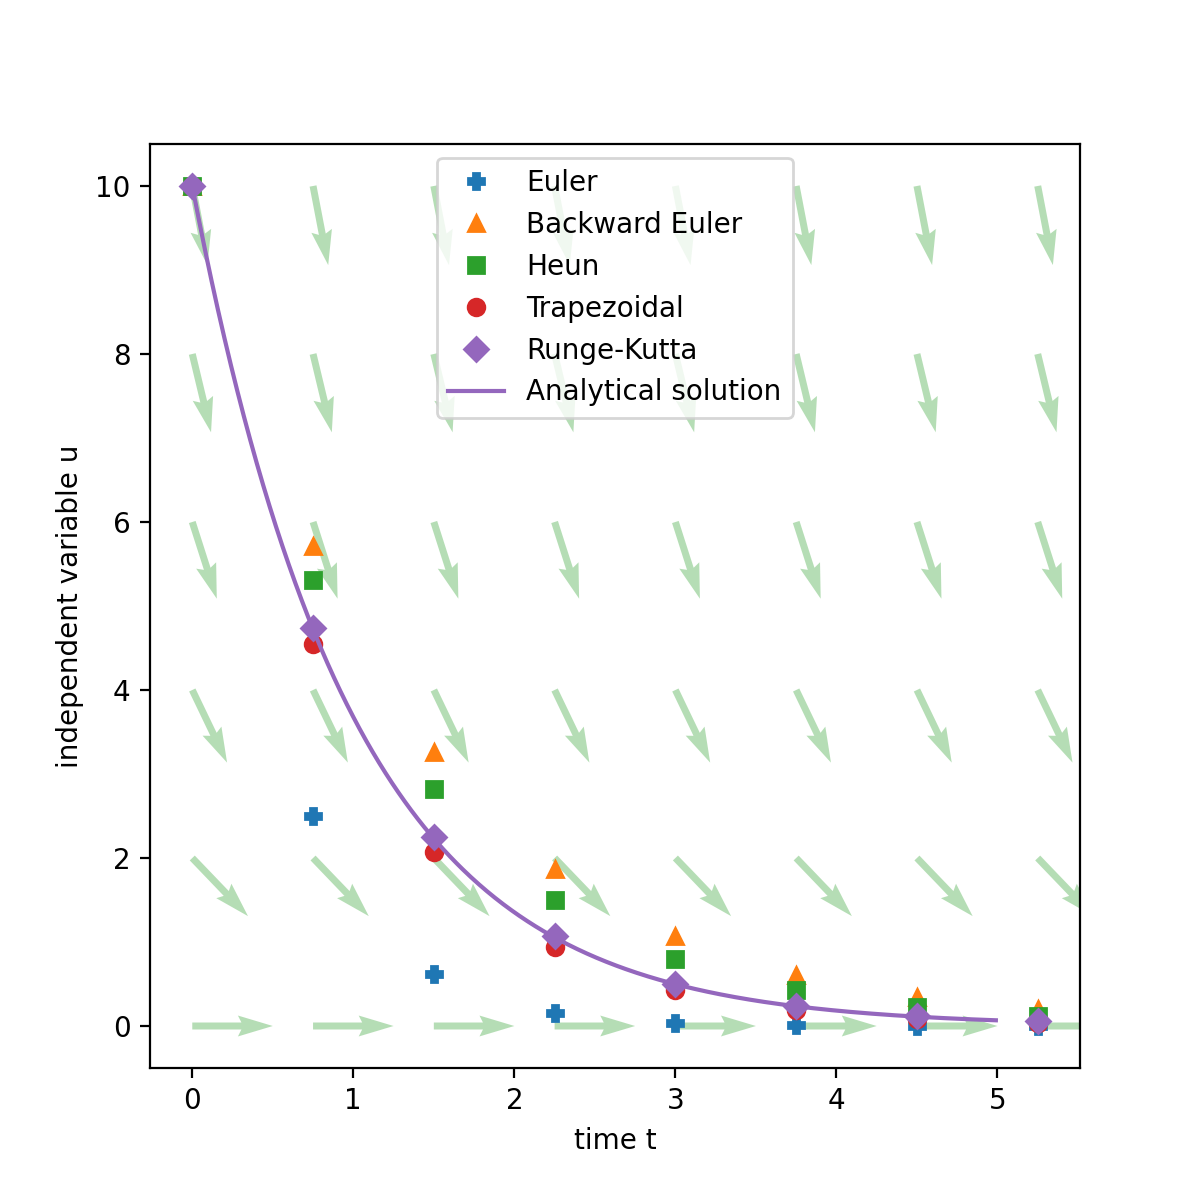

In [5]:
solvers = [forward_euler, backward_euler, heun, trapezoidal, runge_kutta]
symbols = ['P', '^', 's', 'o', 'D']
legends = ['Euler', 'Backward Euler', 'Heun', 'Trapezoidal', 'Runge-Kutta']

compare_numerical_algorithms(h=0.75, T=5, u0=10, show_df=True)

The next cell compares the true solution `u(t)` evaluates at `t=nh` with the approximations `u_n` defined by our numerical methods. We plot the logarithmic errors $\max_{0\leq t\leq T} \log(|u(nh)-u_n|)$ against $\log(h)$ to see how good our approximations are. We expect to see that the logarithmic errors align with lines whose slopes give the order of the numerical methods. The code below also applies linear regression to calculate the slopes of the logarithmic errors for each methods.

In [6]:
def compare_numerical_errors(T, dtMax, u0, M):
    steps = np.log(dtMax/np.linspace(1, M, M))
    errors = np.zeros(M)
    slopes = 'Slopes of fitted lines:\n'
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # cycle through solvers
    for k, solver in enumerate(solvers):
        # cycle through step sizes
        for m in range(M):
            dt = dtMax/(1+m)
            N = int(round(float(T)/dt))
            u = np.zeros(N+1)
            t = np.linspace(0, N*dt, len(u))
            u[0] = u0

            ua = test_solution(t, u0)
            u = solver(test_rhs, u, dt, t)
            errors[m] = np.log(np.max(np.abs(u-ua)))
        plt.plot(steps, errors, linestyle="None", marker=symbols[k])
        coeff = np.polyfit(steps, errors, 1)
        slopes += '{:14} = {:.2f}\n'.format(legends[k], coeff[0])

    ax.set(xlabel='$\log h$', ylabel='$\max \log |u(nh)-u_n|$')
    ax.text(0.02, 0.48, slopes,
         verticalalignment='top', horizontalalignment='left', transform=ax.transAxes,
         color='tab:blue', fontsize=10, fontfamily='monospace')
    ax.legend(legends)
    plt.show()

<IPython.core.display.Javascript object>


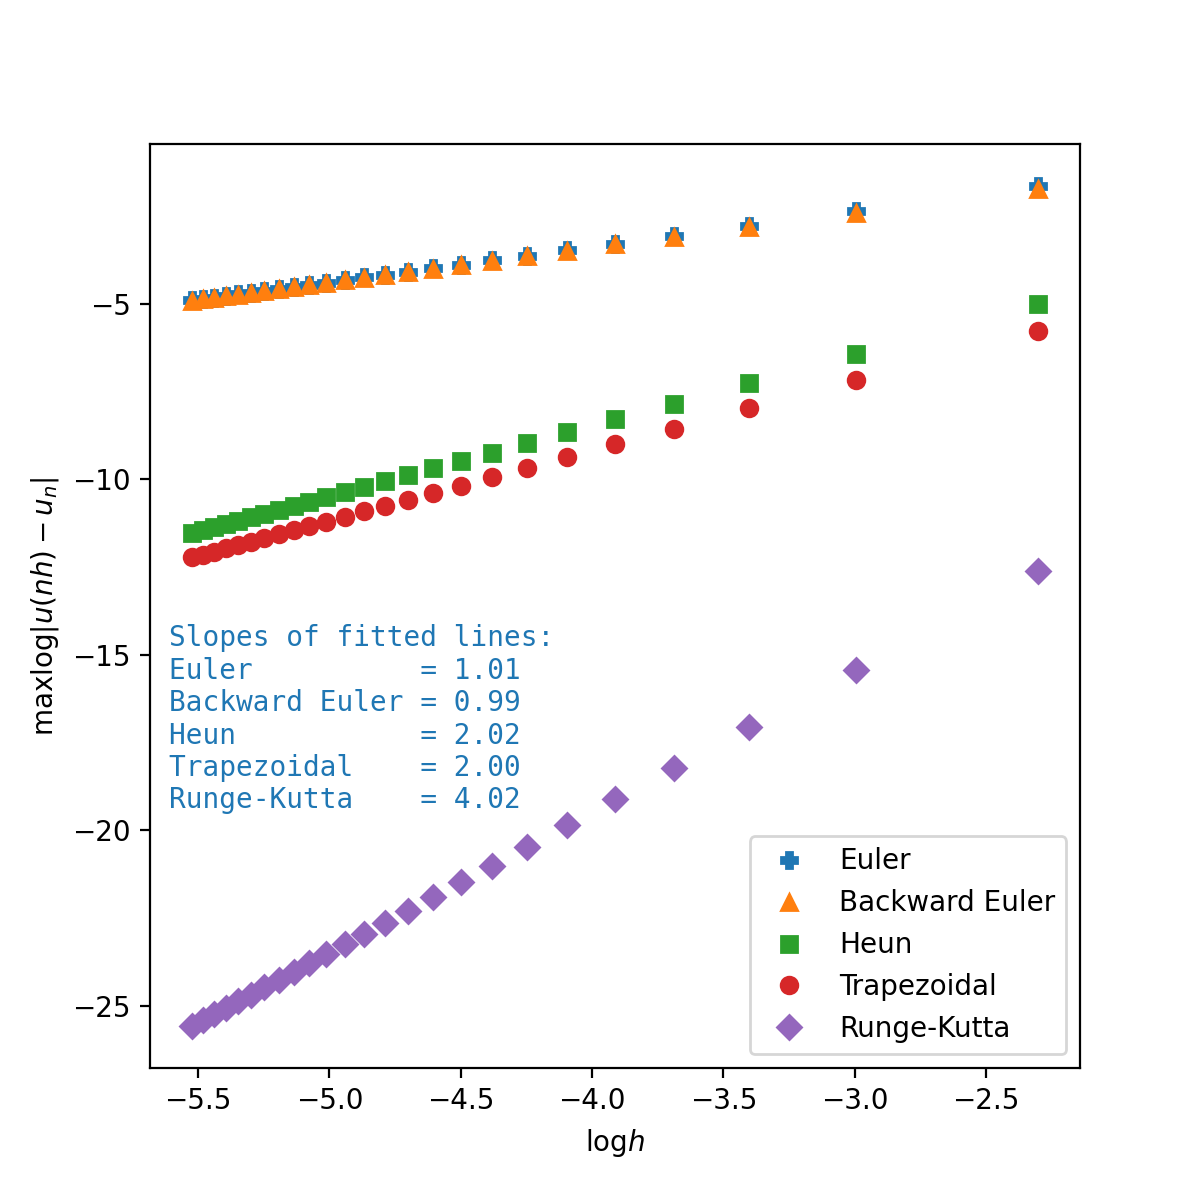

In [7]:
compare_numerical_errors(T=5, dtMax=0.1, u0=10, M=25)